<img src="UBC_Siam_Banner_2017.png" alt="SVDS" width="300" align="left">

***
# UBC Society of Industrial and Applied Mathematics
## Weather & Seasonal Analysis of Direct Tap's Beer Sales in Vancouver, BC
***

### Data Scientists:
OBSCURED FOR PRIVACY

***
### Import Functions
A number of customized python functions were written by various people for this project.  
Rather than overwhelming the reader with python code, we've written these functions in "directtap_functions.py", which is imported below for use in this notebook.  

In [1]:
# Import custom functions
%matplotlib inline
from directtap_functions import *

***
### Define File Paths
If one is actually running this code rather than simply examining this notebook, it is important to properly define the following paths.  

In [2]:
# Define read + write paths

read_Path_Sales = r'data/All_Dates_Final_Updated_Total_Sales_6-5-17.csv'
read_Path_Lat_Long = r'data/Vancouver_Addresses_Lat_Long_6-5-2017.json'
read_Path_Weather = r'darksky_weather_data.csv'
write_Path = r'data/'

***
### Import and Clean Provided Data
The first few team work sessions consisted primarily of data cleaning processes.  

It is of our view that while it is excellent that significant data collection has occured at Direct Tap for the past few years, it is advisable to have an experienced Data Engineer standardize your data input so that input errors are minimized and all data becomes readily useable on demand.    

The following function imports the data into a pandas dataframe, cleans input errors, and aggregates Vancouver Beer deliveries into a ready-to-process dataframe called "df_Sales".

In [3]:
# Import, clean and display data
df_Sales = generate_Clean_df_Sales(read_Path_Sales)
print_all(df_Sales, numrows=10) # maximum numrows to display is 5000
df_Sales.info() # show some information about the dataframe

,requested_delivery_date,establishment_name,address_1,qty,ltr_btl,btl_cs,total_Litres
0,2015-02-03,The Granville Strip (formerly Fan Club),1050 Granville Street,1.0,50.000,1.0,50.00
1,2015-02-03,The Granville Strip (formerly Fan Club),1050 Granville Street,1.0,50.000,1.0,50.00
2,2015-02-03,Westin Grand Hotel,433 Robson Street,3.0,20.000,1.0,60.00
3,2015-02-03,ROYAL CANADIAN LEGION BRANCH NO. 176,1407 LABURNUM Street,3.0,50.000,1.0,150.00
4,2015-02-05,Tap & Barrel - Olympic Village,1 Athletes Way,1.0,50.000,1.0,50.00
...,...,...,...,...,...,...,...
77472,2017-04-29,1st Avenue Liquor Store,243 - 2800 East 1st Avenue,1.0,0.355,24.0,8.52
77473,2017-04-29,Cedar Cottage Neighbourhood Liquor Store,3728 Clark Drive,1.0,0.355,24.0,8.52
77474,2017-04-30,A.N.Z.A. CLUBROOMS,3 W 8TH AVE,1.0,50.000,1.0,50.00
77475,2017-04-30,Buckstop,833 Denman Street,1.0,0.750,12.0,9.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77477 entries, 0 to 77476
Data columns (total 7 columns):
requested_delivery_date    77477 non-null object
establishment_name         77477 non-null object
address_1                  77477 non-null object
qty                        77477 non-null float64
ltr_btl                    77477 non-null float64
btl_cs                     77477 non-null float64
total_Litres               77477 non-null float64
dtypes: float64(4), object(3)
memory usage: 4.1+ MB


***
### Translate Addresses to Geocoordinates 
While we didn't end up doing a lot of individualized seasonal analysis (e.g. seasonality within BC liquor store orders, etc.), we wanted to be able to aggregate sales data by specific customer.  

We translated addresses into latitude longitude data and stored the results in a python dictionary ("lat_Long_Dict"). In this way, the MapQuest API we used did the locational processing for us and standardized the locations.  

One example of why we needed to do this could be "1050 Granville Street" vs. "1050 Granville St., V6Z 1L5". While this is clearly the same customer, it's not trivial to standardize in order to pull aggregate data for this customer.  

We tried some text similarity algorithms to attempt to resolve these discrepencies, but ran into problems with things like "101 Main Street" vs. "1010 Main Street". The Mapquest API solved these descrepancies nicely with geolocational data.

In [4]:
# Load latitude and longitudes dictionary (stored in .json format)

with open(read_Path_Lat_Long, 'r') as file_to_load:
    lat_Long_Dict = json.load(file_to_load)


# Uncomment the following to create a new dictionary of addresses and latitudes/longitudes
'''
lat_Long_Dict = convert_Address_Lat_Long(np.sort(np.array(list(df_Sales.address_1.unique())))) # create dictionary
with open('lat_long_outputs.json', 'w') as fp: # save dictionary in JSON format
    json.dump(lat_Long_Dict, fp, sort_keys=True, indent=4)
'''


# Print an example call to this dictionary

print('Dictionary output in [latitude, longitude] format:')
print(lat_Long_Dict["3014 GRANVILLE Street"])
print(lat_Long_Dict["3014 Granville Street"])

Dictionary output in [latitude, longitude] format:
[49.258587, -123.138743]
[49.258587, -123.138743]


In [5]:
# Add latitude and longitude information to df_Sales dataframe
df_Sales = resolve_Location_Discrepancies(df_Sales, lat_Long_Dict)
print_all(df_Sales, numrows=5) # maximum numrows to display is 5000
df_Sales.info() # show some information about the dataframe

,requested_delivery_date,establishment_name,address_1,qty,ltr_btl,btl_cs,total_Litres,latitude,longitude,agg_Name_Lat_Long
0,2015-02-03,The Granville Strip (formerly Fan Club),1050 Granville Street,1.0,50.00,1.0,50.0,49.278776,-123.123747,49.278776-123.123747
1,2015-02-03,The Granville Strip (formerly Fan Club),1050 Granville Street,1.0,50.00,1.0,50.0,49.278776,-123.123747,49.278776-123.123747
...,...,...,...,...,...,...,...,...,...,...
77475,2017-04-30,Buckstop,833 Denman Street,1.0,0.75,12.0,9.0,49.290899,-123.136298,49.290899-123.136298
77476,2017-04-30,Buckstop,833 Denman Street,1.0,0.50,12.0,6.0,49.290899,-123.136298,49.290899-123.136298


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77477 entries, 0 to 77476
Data columns (total 10 columns):
requested_delivery_date    77477 non-null object
establishment_name         77477 non-null object
address_1                  77477 non-null object
qty                        77477 non-null float64
ltr_btl                    77477 non-null float64
btl_cs                     77477 non-null float64
total_Litres               77477 non-null float64
latitude                   77477 non-null float64
longitude                  77477 non-null float64
agg_Name_Lat_Long          77477 non-null object
dtypes: float64(6), object(4)
memory usage: 5.9+ MB


***
### Examine Individual Customers
Given a specific customer, we call upon their order history and compare their yearly purchases.

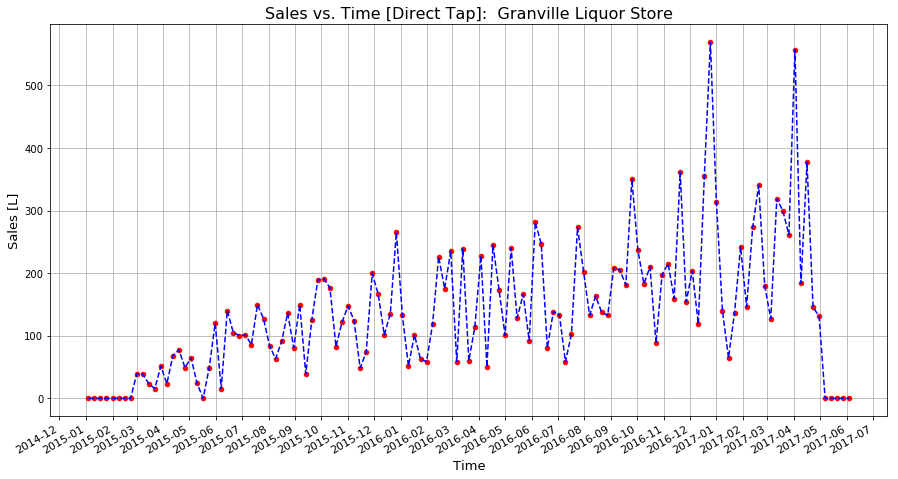

In [6]:
# Specify customer and display individual sales

customer = 'Granville Liquor Store'
period = 'W'
    
plot_Individual_Sales_Trend(df_Sales, customer=customer, period=period)

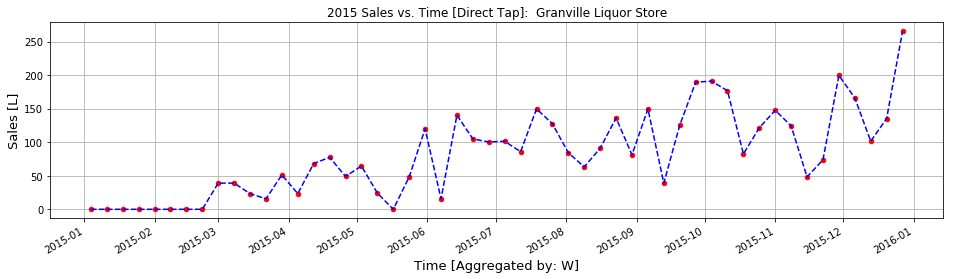

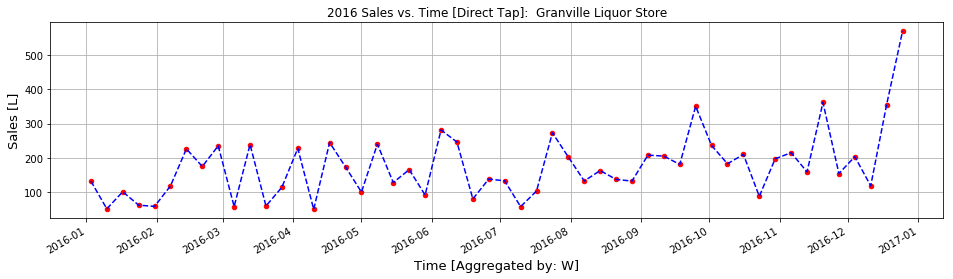

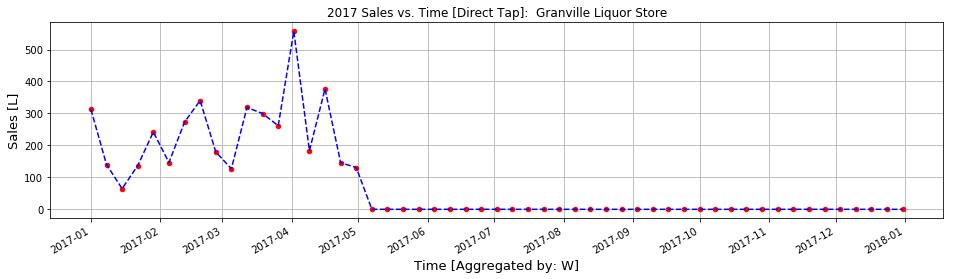

In [7]:
# Compare year-to-year sales of specified customer -- note the possible scale changes on the y-axis.
# Essentially, this breaks up the plot above to eyeball possible seasonal trends for given customer.

customer = 'Granville Liquor Store'
period = 'W'

compare_Customer_Sales_Years(df_Sales, customer=customer, period=period)

***
### Aggregate Net Sales
Here, we aggregate orders made over all the same day. In doing so we lose individual customer order information, but get a better picture of net Vancouver beer demand on Direct Tap business.  

We then perform some statistical examination of seasonality for the net sales data.

In [8]:
# Aggregate orders made on the same day across all customers
df_Sales_Net = get_Net_Orders(df_Sales)
print_all(df_Sales_Net, numrows=5) # maximum numrows to display is 5000
df_Sales_Net.info() # show some information about the dataframe

,total_Litres
requested_delivery_date,
2015-02-03,310.0
2015-02-05,50.0
...,...
2017-04-29,1660.0
2017-04-30,65.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 747 entries, 2015-02-03 to 2017-04-30
Data columns (total 1 columns):
total_Litres    747 non-null float64
dtypes: float64(1)
memory usage: 11.7 KB


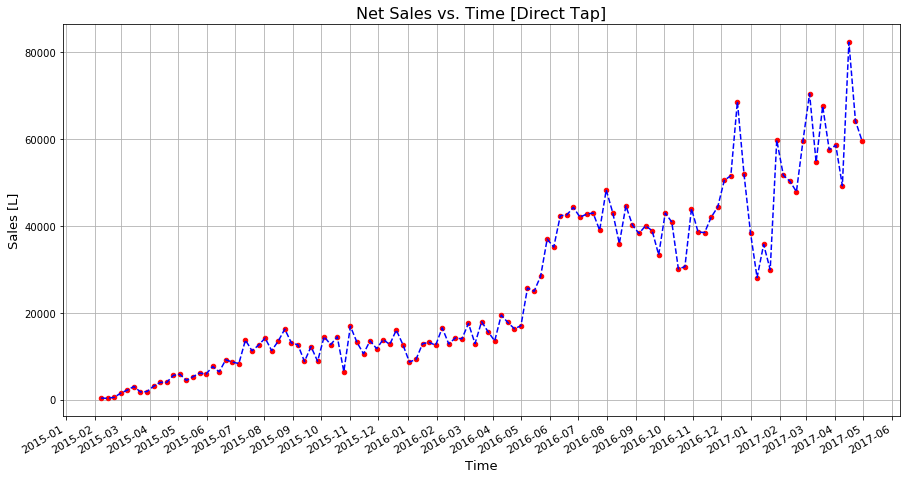

In [9]:
# Plot net demand vs date, aggregating sales over specified period

period = 'W'

plot_Sales_Trend(df_Sales_Net, period=period)

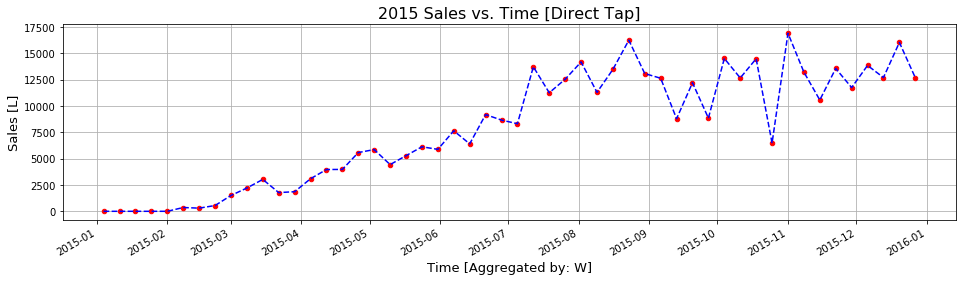

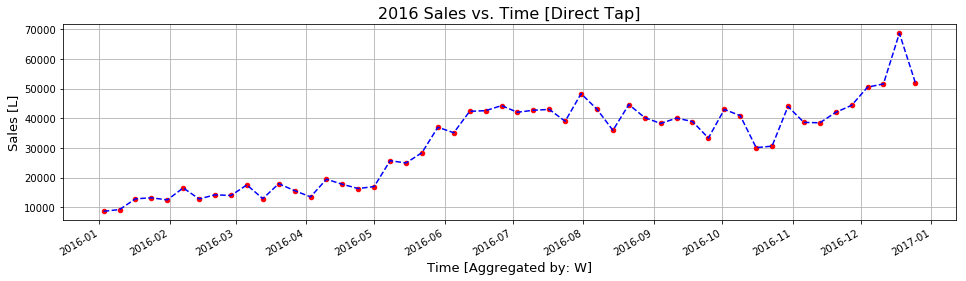

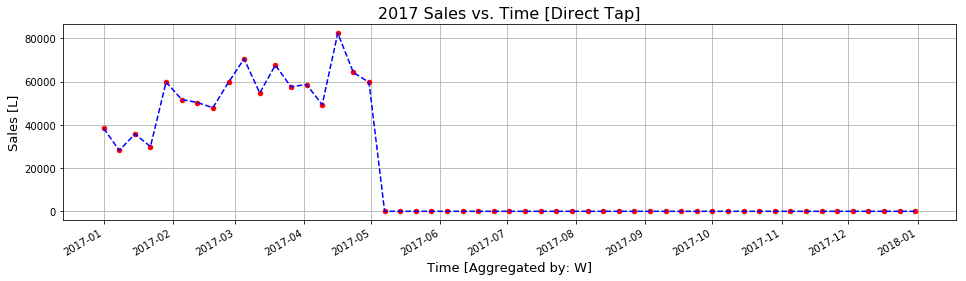

In [10]:
# Plot year-to-year comparison of net sales

period = 'W'

compare_Sales_Years(df_Sales_Net, period=period)

***
### Isolate for Seasonal Trends
Starting here, the y-axis starts to be a little less intuitive.  

What we do is isolate for seasonal variations by subtracting the actual aggregated sales from the best fit regression line of the aggregate sales (more or less the rolling mean of sales). In this way, we can create a "percent sales variation from expected", which should give us a good estimate of seasonal trends.  

This will make more sense in the below cells.

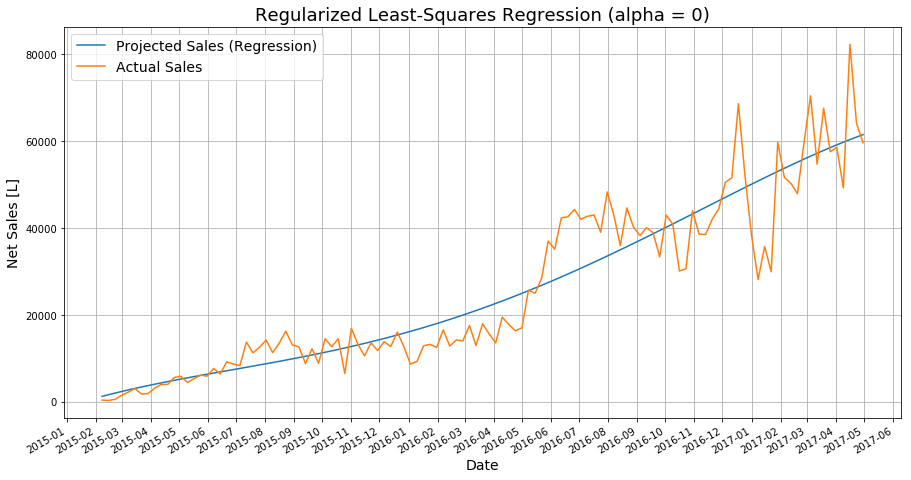

In [11]:
# Model and display the results of aggregate sales

agg_Period = 'W'

model, best_Fit_Data, df_Sales_Net_Model = regularized_Lin_Reg(df_Sales_Net, agg_Period=agg_Period, alpha=0, degree=4)

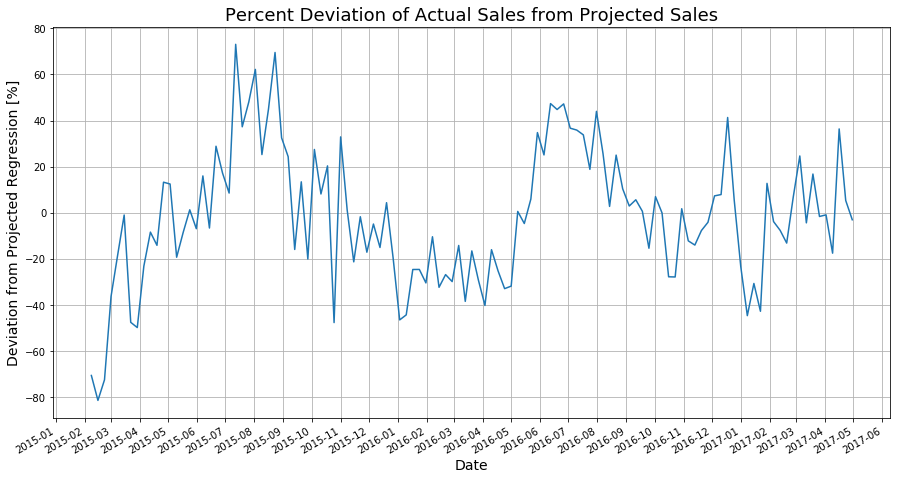

In [12]:
# Plot deviation from best-fit over time

percent_Deviation = plot_Deviation(df_Sales_Net_Model, best_Fit_Data)

***
### Box-Plot Above Results
It is clear that already we're seeing some sort of seasonal variation to this data, and the result is intuitive: sales exceed their expected value should the business continue growing as usual by ~40-75% in the Summer and fall short of projected sales in Winter months.

Another way to visualize this seasonality is through a monthly box plot. More information on box plots here: http://www.physics.csbsju.edu/stats/box2.html

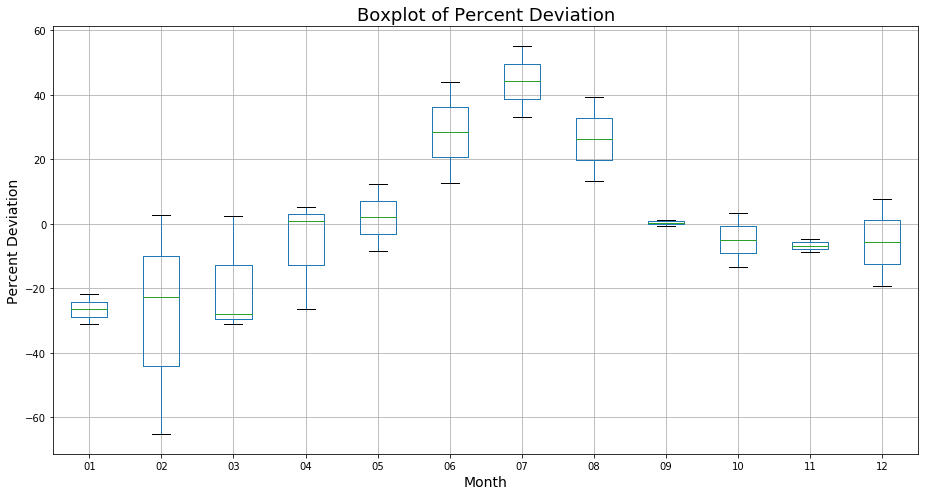

In [13]:
box_Plot(percent_Deviation)

***
### Average Yearly Deviations
Averaging the ~2 years worth of seasonality results in the following plot

/home/leo/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


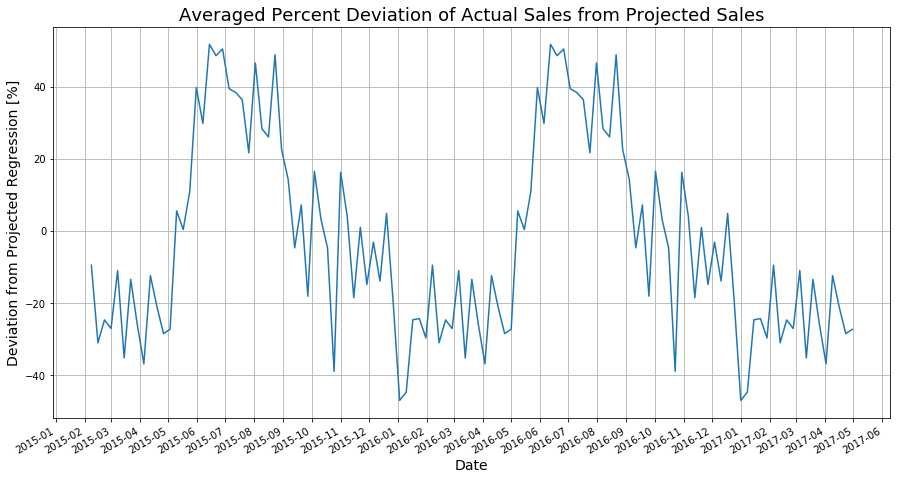

In [14]:
# Average yearly seasonal trends

average_Seasonality(df_Sales_Net_Model)

***
### Correlate Sales Demand and Weather
While it's all good and well to examine seasonal fluctuation in sales demand, our requested hypothesis was **weather drives demand**.  

We were able to pull temperature data from Dark Sky, a free weather API.  

We then saw if weather correlated with beer demand. Our outputs are interesting and mostly intuitive.

In [15]:
# Pull in weather data (info: https://darksky.net/dev/docs/response)

df_Weather = read_Darksky_Weather_Data(read_Path_Weather)
print_all(df_Weather, numrows=5)
df_Weather.info()

,Date,icon,precipIntensity,precipIntensityMax,precipProbability,apparentTemperatureMin,apparentTemperatureMax,humidity,windSpeed,cloudCover
Date,,,,,,,,,,
2015-02-03,2015-02-03,2,0.0052,0.0436,0.71,41.54,47.02,0.94,2.34,0.00
2015-02-04,2015-02-04,2,0.0037,0.0207,0.61,39.46,46.18,0.92,2.54,0.00
...,...,...,...,...,...,...,...,...,...,...
2017-04-11,2017-04-11,5,0.0004,0.0045,0.18,38.90,52.88,0.76,2.45,0.77
2017-04-12,2017-04-12,2,0.0151,0.0723,0.77,40.99,51.31,0.81,4.71,0.97


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 798 entries, 2015-02-03 to 2017-04-12
Data columns (total 10 columns):
Date                      798 non-null object
icon                      798 non-null object
precipIntensity           798 non-null float64
precipIntensityMax        798 non-null float64
precipProbability         798 non-null float64
apparentTemperatureMin    798 non-null float64
apparentTemperatureMax    798 non-null float64
humidity                  798 non-null float64
windSpeed                 798 non-null float64
cloudCover                798 non-null float64
dtypes: float64(8), object(2)
memory usage: 68.6+ KB


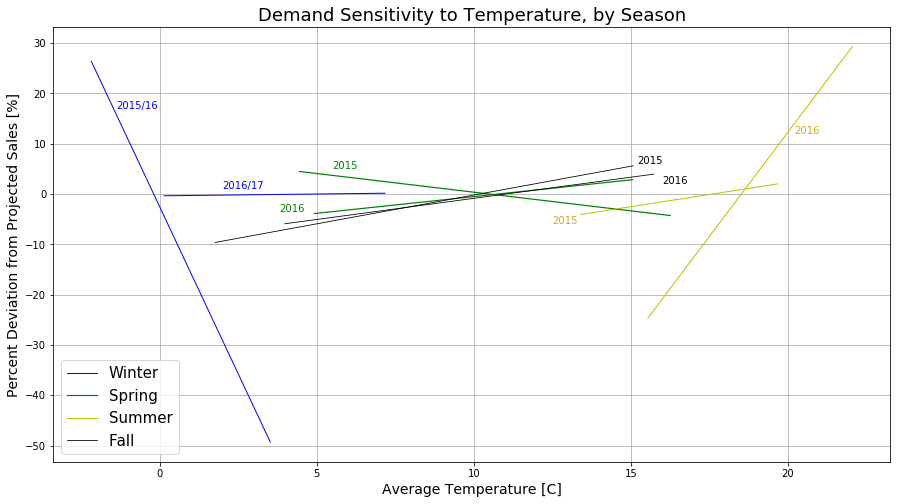

In [16]:
# Plot seasonal breakdown of weather driving demand
model_Seasonal_Weather_Variation(df_Sales_Net, df_Weather, plot_All=False, agg_Period = 'W', temp_Lag = '3 days')

***
### Analysis of Above Plot
It seems like Winter and Summer demand can be more sensitive to temperature variation than Fall or Spring.  

In particular, a hotter Summer and colder Winter show high sensitivity to weather.  

Possible explanations include Christmas and New Years (late December/early January are often the coldest periods of the year) and the intuitive thought that hotter temperatures in the summer lead to increased demand for beer (camping, patio-drinking, general increased desire to do fun things including beer).

It is important for us to assert that there are a number of unnaccounted confounding factors here, and this analysis has a high degree of uncertainty as a result. Nevertheless, it is an interesting outcome for a seasonal breakdown.

***
### Conclusion
It was really great to get access to your data and try to make some meaningful conclusions from it.

Thanks for the opportunity and the beer!

Regards,

UBC SIAM 2017